# Setup

In [2]:
import cv2 as cv
print("OpenCV-Python Version {}".format(cv.__version__))
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import math


OpenCV-Python Version 4.9.0


In [ ]:
## Execute this when running the notebook on google colab
from google.colab import drive
drive.mount('/content/drive')
# Then change this to your own folder path containing the notebook
folder_path = "/content/drive/MyDrive/TREC_Codage/"

Mounted at /content/drive


In [ ]:
folder_path = ""

In [128]:
image_file = "IMG_0009.png"
image_path = f"{folder_path}scan_resultsheets/{image_file}"
print(image_path)

scan_resultsheets/IMG_0009.png


# Detection of boxes contours

## Functions

In [4]:
# Function to detect box contours
def extract_boxes(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 170, 250, cv.THRESH_BINARY_INV) # Modify threshold in case of issues with box detection
    # In case of threshold optimisation: visualise thresholded image
    plt.imshow(thresh)
    plt.show()
    contours, _ = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    extracted_boxes = []
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        if(w>=90 and w<100):
            aspect_ratio = w/h
            if aspect_ratio <= 1.15:
                extracted_boxes.append((x, y, w, h))
    # Reorder box list to have top to bottom list
    extracted_boxes = np.array(extracted_boxes)
    extracted_boxes = np.flip(extracted_boxes, axis=0)
    return extracted_boxes

In [147]:
# Function to visualize detected boxes on scanned resultsheet
def plot_boxes(image, boxes):
    image_copy = image
    if boxes.ndim > 1:
        for gbox in boxes :
            x, y, w, h = gbox
            cv.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
    else :
        x, y, w, h = boxes
        cv.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.figure(figsize=(10,8))
    plt.imshow(cv.cvtColor(image_copy, cv.COLOR_BGR2RGB))
    plt.title("Detected Boxes")
    plt.axis('off')
    plt.show()


In [151]:
def reorder_box(box):
    # We want boxes in order : left -> right (x asc), top -> bottom (y asc)
    # To avoid little variations in the line, which will mess up the sort
    # We replace each line and each column of 20 by the mean y and mean x
    boxdf = pd.DataFrame(box, columns = ['x', 'y', 'w', 'h'])
    boxdf_sorted = boxdf.copy()
    # Sort the df on y, and replace y for the line of 20 by mean y
    boxdf_sorted = boxdf_sorted.sort_values(by = 'y', ignore_index = True)
    for i in range(0, 400, 20):
        boxdf_sorted.loc[i:i+19, 'y'] = round(boxdf_sorted.loc[i:i+19, 'y'].mean(), 0)
    # Sort the df on x, and replace x for the line of 20 by mean x
    boxdf_sorted = boxdf_sorted.sort_values(by = 'x', ignore_index = True)
    for j in range(0, 400, 20):
        boxdf_sorted.loc[j:j+19, 'x'] = round(boxdf_sorted.loc[j:j+19, 'x'].mean(), 0)
    # Finally sort by ascending y then x
    boxdf_sorted = boxdf_sorted.sort_values(by = ['y', 'x'], ignore_index = True)
    box_sorted = boxdf_sorted.to_numpy()
    return box_sorted

In [7]:
def affiche_scan(img):
    # Display scanned resultsheet with horizontal and vertical lines
    rows,cols, _ = img.shape
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axhline(rows//2, color='r', linewidth=1)
    plt.axvline(cols//2, color='g', linewidth=1)
    plt.show()
def image_rotation(img, degree):
    # Rotate an image of a certain degree counterclockwise
    rows,cols, _ = img.shape
    M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),degree,1)
    img_rot = cv.warpAffine(img,M,(cols,rows))
    affiche_scan(img_rot)
    return img_rot


## Detection

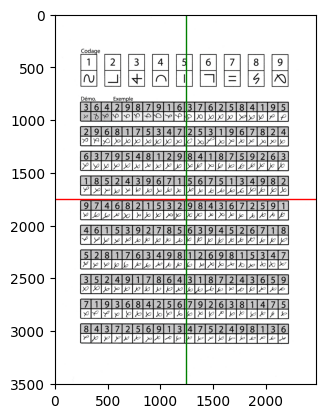

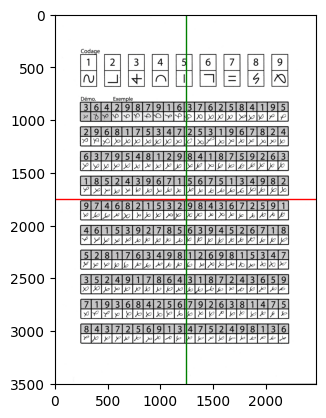

In [148]:
# Image rotation
img = cv.imread(image_path)
affiche_scan(img)
img_rot = image_rotation(img, 0.1)

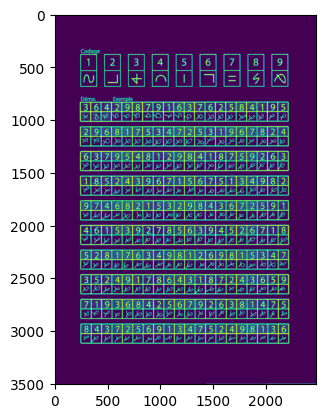

(400, 4)
[1179.6675 1935.2225   92.4275   84.5375]


In [131]:
# Creation of box which is the list of all boxes coordinates
box = extract_boxes(img_rot)
print(box.shape)
print(box.mean(axis=0))
# Shape must be (400, 4), otherwise adjust functions parameters

In [132]:
# Do not run if not all boxes are detected
box = reorder_box(box)
print(box.mean(axis=0))

[1179.75   1935.15     92.4275   84.5375]


[344 838  91  84]


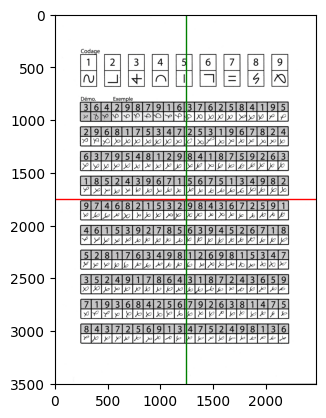

In [149]:
print(box[1])
affiche_scan(img_rot)

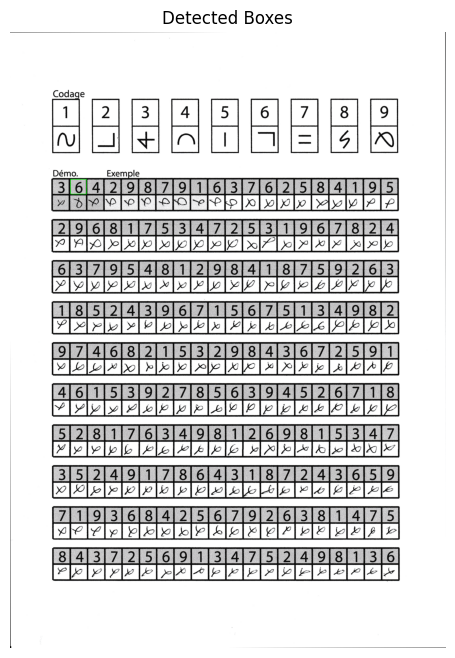

In [150]:
plot_boxes(img_rot, box[1])

### Issues

#### #1 Parfois toutes les boites ne sont pas détectées

Cela semble être le cas quand il y a un trou dans la ligne (old/IMG_0003),
ou quand le contenu de la case se superpose avec les limites de la case (old/IMG_0004, new IMG_0003, new IMG_0007). Spécifiquement, la boite n'est pas détectée quand le symbole croise les limites de la case 2 fois

* Fix 1: Adapter le code suivant pour qu'il fonctionne sur tous les nombres de boites: OK
* Fix 2: Améliorer la détection des boites avec cv.findcontours
* Fix 3: Utiliser un template pour détecter les boites

#### #2 Boite qui ressors avec le mauvais index
Résolu par la fonction reorder_box

#### #3 Issue with plot_box function
Function is not plotting specified boxes but rather all boxes : fixed by copying image for function display

# Extraction of symbols (ROI) located inside the boxes

## Functions

In [25]:
# Une fonction pour extraire les roi situées à l'intérieur des boites
arbitrary_width = 87
arbitrary_height = 80
def extract_roi_inside_box(img, box):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    x, y, w, h = box
    roi = gray[y+4:y+arbitrary_height, x+5:x+arbitrary_width]
    #roi = gray[y+4:y+arbitrary_height-4, x+4:x+arbitrary_width-4]
    return roi

In [51]:
# Liste des index des cases à symboles
intervals = [(20, 40), (60, 80), (100, 120), (140, 160), (180, 200), (220, 240), (260, 280), (300, 320), (340, 360), (380, 400)]
symbols_index = np.concatenate([np.arange(start, end, 1) for start, end in intervals])
print(symbols_index)
# Liste des index des cases à nombres
all_index = np.arange(0, 400, 1)
number_index = np.setdiff1d(all_index, symbols_index)
print(number_index)

[ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 260 261 262 263 264 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 279 300 301 302 303
 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  80  81  82  83  84  85 

## If all the boxes are detected : Extraction

In [134]:
# Extraction: création de la liste de toutes les images contenues dans les boites
# Use only if all boxes are detected
roi_symbols = []
for coord in box[symbols_index] :
    roi_img = extract_roi_inside_box(img_rot, coord)
    roi_symbols.append(roi_img)

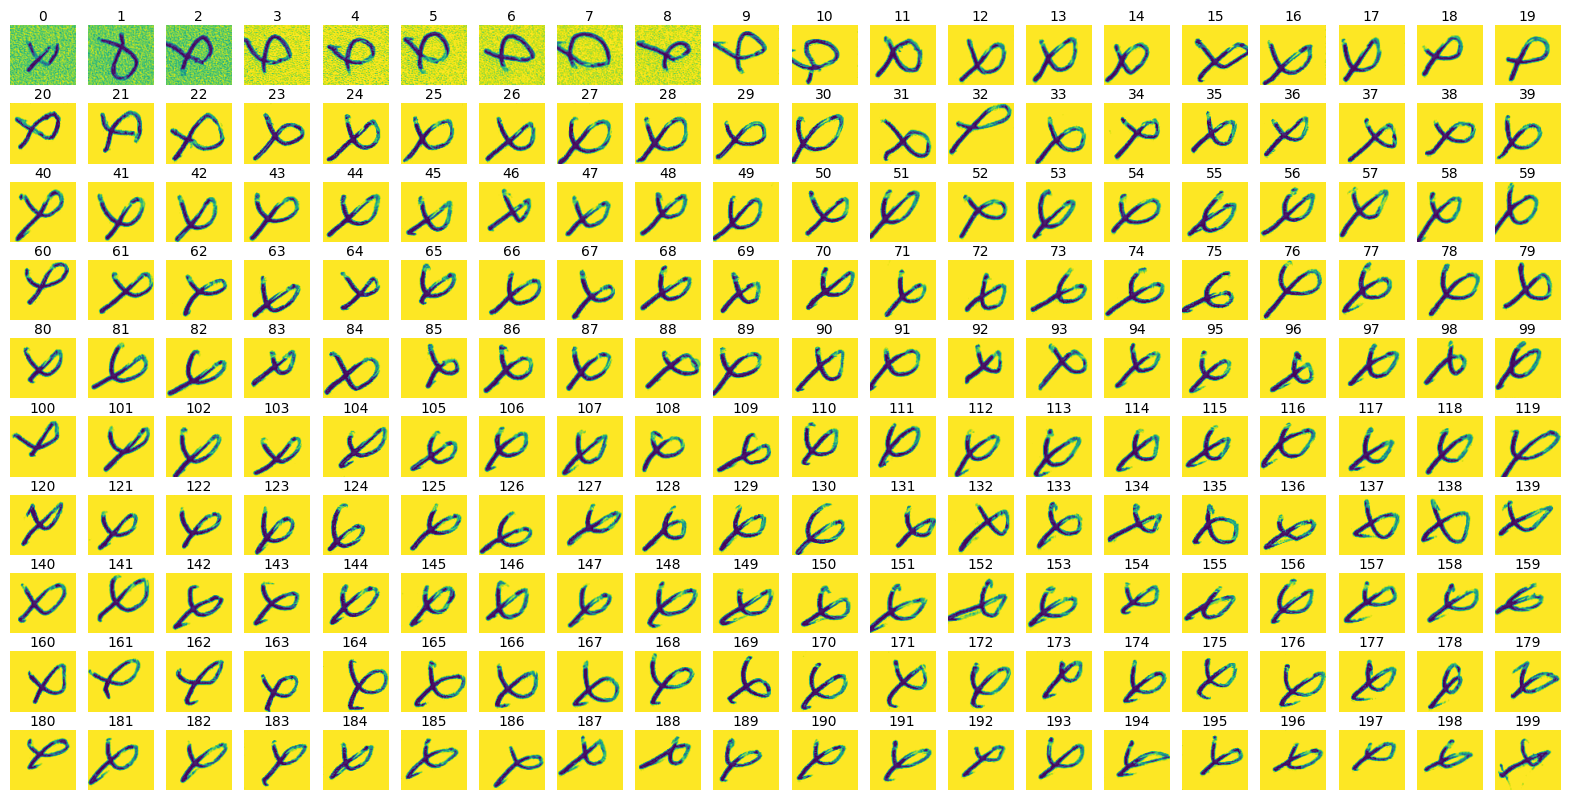

In [135]:
# Affichage des symboles en lignes de 20
n_rows = math.ceil(len(roi_symbols) / 20)
fig, axs = plt.subplots(n_rows, 20, figsize=(20, n_rows))

for i, pixels in enumerate(roi_symbols):
    row = i // 20
    col = i % 20
    ax = axs[row, col]
    ax.imshow(pixels)
    ax.text(0.5, 1.02, str(i), transform=ax.transAxes, ha='center', va='bottom', fontsize=10)
    ax.axis('off')

plt.show()

## If not all the boxes are detected : separation by mean pixel

In [115]:
# Extraction: création de la liste de toutes les images contenues dans les boites
roi_all = []
for coord in box :
    roi_img = extract_roi_inside_box(img_rot, coord)
    roi_all.append(roi_img)

(398, 76, 82)
(398,)


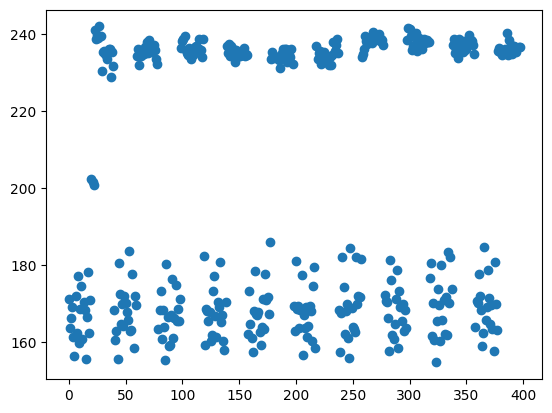

In [116]:
# Exploration de roi_all
roi_all = np.array(roi_all)
print(roi_all.shape)
mean_pix = roi_all.mean(axis=1).mean(axis=1)
print(mean_pix.shape)
plt.plot(mean_pix, 'o')
# Il est possible que les chiffres puissent être séparés des symboles grâce à la moyenne des pixels

(198, 76, 82)


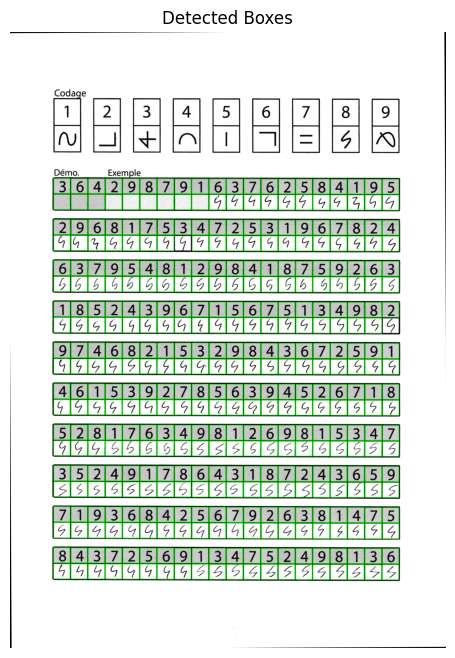

In [117]:
# Tentative de séparation des chiffres et des symboles
high_mean = np.nonzero(mean_pix > 190)
print(roi_all[high_mean].shape)
plot_boxes(img_rot, box[high_mean])
# Si correct, séparer selon le mean pixel
# Sinon utiliser les indices

In [118]:
# Pour les cas ou cela fonctionne bien : séparation selon le mean pixel
roi_symbols = roi_all[high_mean].copy()
print(roi_symbols.shape)
roi_numbers = roi_all[~np.isin(np.arange(len(roi_all)), high_mean)].copy()
print(roi_numbers.shape)

(198, 76, 82)
(200, 76, 82)


# Annotation des données

A utiliser uniquement pour les feuilles de training (monosymboles)

## True labels

In [136]:
# Vrais labels pour les feuilles de training (monosymboles)
train_label = f'{image_file}'
train_label = int(train_label[-5])
true_labels = np.full((len(roi_symbols),), train_label)
print(true_labels)
print(true_labels.shape)
annotation_labels = true_labels.copy()

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
(200,)


## Verification

In [137]:
# Pour les feuilles de training (monosymboles)
# On enlève les cases vides ou avec des erreurs
todelete = list(range(0, 9)) + list([88, 194, 199])
roi_symbols_c = np.delete(roi_symbols, todelete, axis=0)
print(roi_symbols_c.shape)
annotation_labels_c = np.delete(annotation_labels, todelete, axis=0)
print(annotation_labels_c.shape)

(188, 76, 82)
(188,)


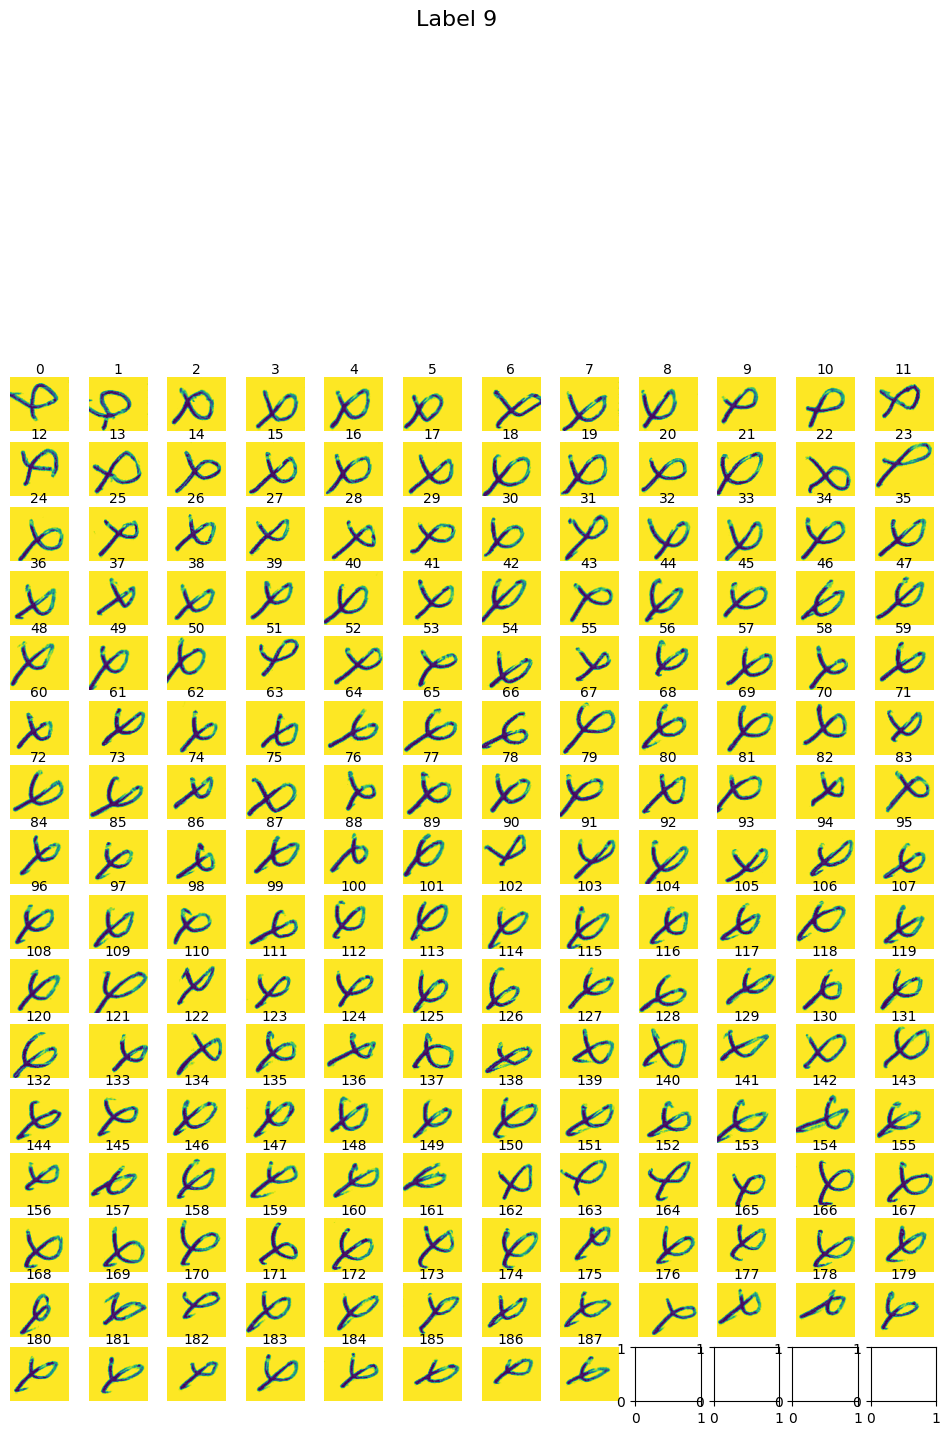

In [138]:
# Annotation: vérification que l'annotation a bien été faite
for label in np.unique(annotation_labels_c):
    label_mask = (annotation_labels_c == label)
    roi_indices = np.where(label_mask)[0]

    n_rows = math.ceil(len(roi_symbols_c[label_mask]) / 12)
    fig, axs = plt.subplots(n_rows, 12, figsize=(12, n_rows))

    for i, pixels in enumerate(roi_symbols_c[label_mask]):
        row = i // 12
        col = i % 12
        ax = axs[row, col]
        ax.imshow(pixels)
        ax.text(0.5, 1.02, str(roi_indices[i]), transform=ax.transAxes, ha='center', va='bottom', fontsize=10)
        ax.axis('off')
    fig.suptitle(f'Label {label}', fontsize=16)
    fig.subplots_adjust(top=0.75)
    plt.show()

# Saving data

In [139]:
# On sauvegarde un fichier csv avec les images et les annotations
# On aplati d'abord roi_symbols en 2 dimensions
roi_symbols_2d = roi_symbols_c.reshape(len(roi_symbols_c), -1)
print(roi_symbols_2d.shape)
full_dataset = np.concatenate((roi_symbols_2d, annotation_labels_c[:, np.newaxis]), axis = 1)
print(full_dataset.shape)
print(image_path)
file_name = image_file.split('.')[0]
np.savetxt(f'{folder_path}data_resultsheets/{file_name}.csv', full_dataset, fmt='%d', delimiter=',')

(188, 6232)
(188, 6233)
scan_resultsheets/IMG_0009.png
